In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['axes.unicode_minus'] = False

In [4]:
df = pd.read_excel("data/Coffee Shop Sales.xlsx")

In [5]:
df.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


In [6]:
set(df.store_id),set(df.store_location)

({3, 5, 8}, {'Astoria', "Hell's Kitchen", 'Lower Manhattan'})

In [7]:
df[['store_id','store_location']].drop_duplicates().sort_values('store_id')

,store_id,store_location
105,3,Astoria
0,5,Lower Manhattan
17,8,Hell's Kitchen


In [8]:
store_dict = df[['store_id','store_location']]
store_dict.head()

,store_id,store_location
0,5,Lower Manhattan
1,5,Lower Manhattan
2,5,Lower Manhattan
3,5,Lower Manhattan
4,5,Lower Manhattan


In [9]:
len(set(df.product_id)),len(set(df.product_detail))

(80, 80)

In [10]:
df[['product_id','product_detail']].drop_duplicates().sort_values('product_id')

,product_id,product_detail
3451,1,Brazilian - Organic
4494,2,Our Old Time Diner Blend
3968,3,Espresso Roast
3554,4,Primo Espresso Roast
4328,5,Columbian Medium Roast
...,...,...
4598,81,I Need My Bean! T-shirt
5327,82,I Need My Bean! Diner mug
4033,83,I Need My Bean! Latte cup
3352,84,Chocolate syrup


In [11]:
product_dict = df[['product_id','product_detail']]
product_dict.head()

,product_id,product_detail
0,32,Ethiopia Rg
1,57,Spicy Eye Opener Chai Lg
2,59,Dark chocolate Lg
3,22,Our Old Time Diner Blend Sm
4,57,Spicy Eye Opener Chai Lg


In [12]:
df_main=df.drop(['transaction_id','transaction_time','store_location','product_detail'],axis=1)\
.eval('sales=transaction_qty*unit_price')\
.pivot_table(index=['transaction_date','store_id','product_id'],values=['transaction_qty','sales','unit_price','product_category','product_type'],
             aggfunc={'transaction_qty':'sum','sales':'sum','unit_price':'first','product_category':'first','product_type':'first'}).reset_index()\
.rename({'sales':'product_revenue'},axis=1).assign(daily_sales=lambda df:df.groupby('transaction_date')['product_revenue'].transform('sum'))
df_main

,transaction_date,store_id,product_id,product_category,product_type,product_revenue,transaction_qty,unit_price,daily_sales
0,2023-01-01,3,22,Coffee,Drip coffee,10.00,5,2.00,2508.20
1,2023-01-01,3,23,Coffee,Drip coffee,17.50,7,2.50,2508.20
2,2023-01-01,3,24,Coffee,Drip coffee,15.00,5,3.00,2508.20
3,2023-01-01,3,25,Coffee,Organic brewed coffee,11.00,5,2.20,2508.20
4,2023-01-01,3,26,Coffee,Organic brewed coffee,12.00,4,3.00,2508.20
...,...,...,...,...,...,...,...,...,...
31759,2023-06-30,8,77,Bakery,Scone,15.00,5,3.00,5481.32
31760,2023-06-30,8,78,Bakery,Scone,36.00,8,4.50,5481.32
31761,2023-06-30,8,79,Bakery,Scone,18.75,5,3.75,5481.32
31762,2023-06-30,8,84,Flavours,Regular syrup,6.40,8,0.80,5481.32


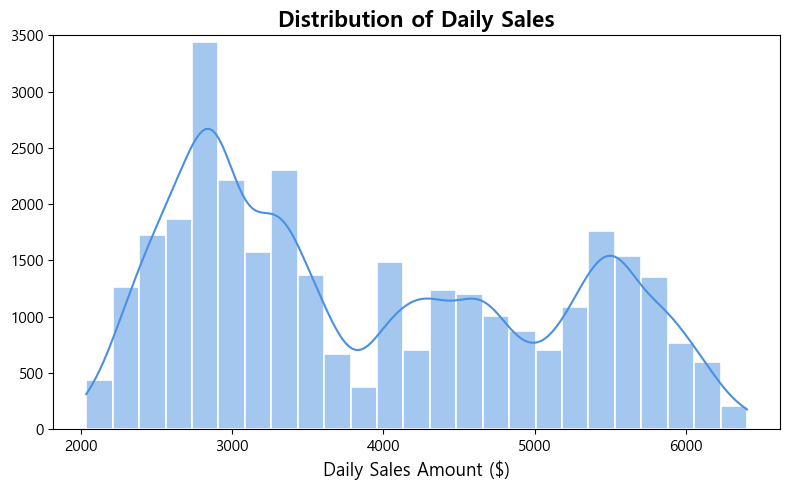

In [41]:
plt.figure(figsize=(8,5))
sns.histplot(
    data=df_main, 
    x='daily_sales', 
    bins=25, 
    kde=True, 
    color="#4A90E2",
    edgecolor='white',
    linewidth=1.2
)

plt.title('Distribution of Daily Sales', fontsize=16, fontweight='bold')
plt.xlabel('Daily Sales Amount ($)', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.ylim(0,3500)
plt.ylabel('')

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()

In [14]:
df_main['daily_sales'].describe()

count    31764.000000
mean      3923.906749
std       1195.496580
min       2037.100000
25%       2868.950000
50%       3575.850000
75%       5052.650000
max       6403.910000
Name: daily_sales, dtype: float64

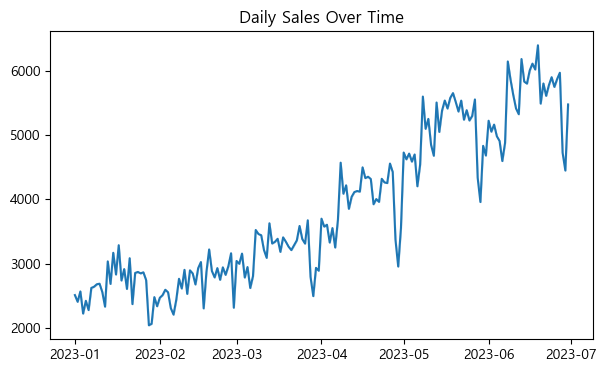

In [42]:
plt.figure(figsize=(7,4))
sns.lineplot(data=df_main, x='transaction_date', y='daily_sales')
plt.title('Daily Sales Over Time')
plt.xlabel('')
plt.ylabel('');

In [16]:
df_location=df_main.pivot_table(index=['transaction_date','store_id'],values='product_revenue',aggfunc='sum').reset_index()
df_location

,transaction_date,store_id,product_revenue
0,2023-01-01,3,868.40
1,2023-01-01,5,788.35
2,2023-01-01,8,851.45
3,2023-01-02,3,925.50
4,2023-01-02,5,649.05
...,...,...,...
538,2023-06-29,5,1299.45
539,2023-06-29,8,1298.55
540,2023-06-30,3,1807.65
541,2023-06-30,5,1768.74


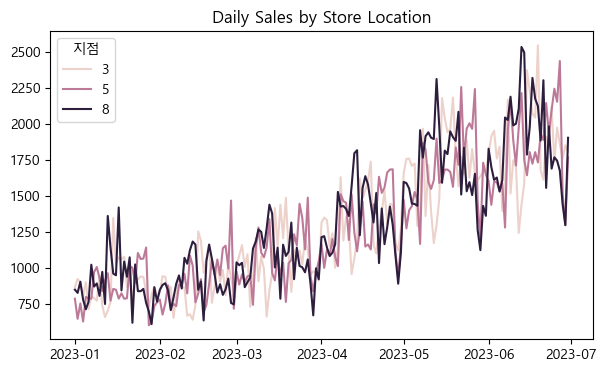

In [43]:
plt.figure(figsize=(7,4))
sns.lineplot(data=df_location, x='transaction_date', y='product_revenue',hue='store_id')
plt.title('Daily Sales by Store Location')
plt.xlabel('')
plt.ylabel('')
plt.legend(title='지점');

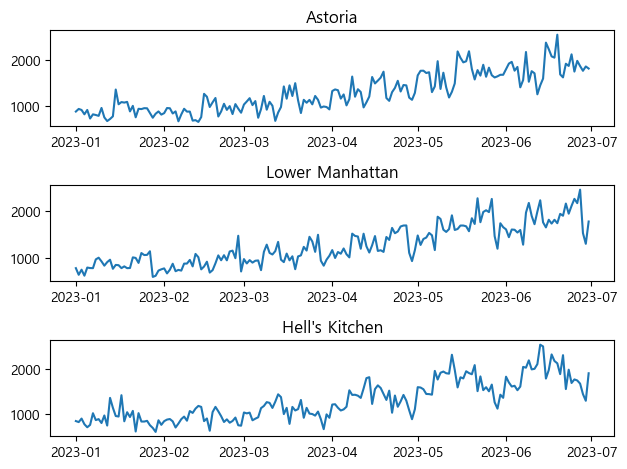

In [45]:
plt.subplot(3,1,1)
sns.lineplot(data=df_location.query('store_id==3'), x='transaction_date', y='product_revenue')
plt.title('Astoria')
plt.xlabel('')
plt.ylabel('')

plt.subplot(3,1,2)
sns.lineplot(data=df_location.query('store_id==5'), x='transaction_date', y='product_revenue')
plt.title('Lower Manhattan')
plt.xlabel('')
plt.ylabel('')

plt.subplot(3,1,3)
sns.lineplot(data=df_location.query('store_id==8'), x='transaction_date', y='product_revenue')
plt.title("Hell's Kitchen")
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

In [22]:
from scipy.stats import f_oneway

- $H_0$ : 지점별 평균 일매출 차이가 없다
- $H_1$ : not $\, H_0$

In [24]:
store3 = df_location.query('store_id==3')['product_revenue']
store5 = df_location.query('store_id==5')['product_revenue']
store8 = df_location.query('store_id==8')['product_revenue']
f_stat,p_val = f_oneway(store3,store5,store8)
p_val

0.726331765882503

In [36]:
df_category = df_main.groupby(['transaction_date','product_category']).agg({'product_revenue':'sum'}).reset_index()\
.groupby('product_category').agg({'product_revenue':'mean'}).reset_index()
df_category

,product_category,product_revenue
0,Bakery,454.782541
1,Branded,110.626016
2,Coffee,1491.450000
3,Coffee beans,299.143657
4,Drinking Chocolate,400.088398
5,Flavours,62.752239
6,Loose Tea,84.312782
7,Packaged Chocolate,35.261120
8,Tea,1085.115746


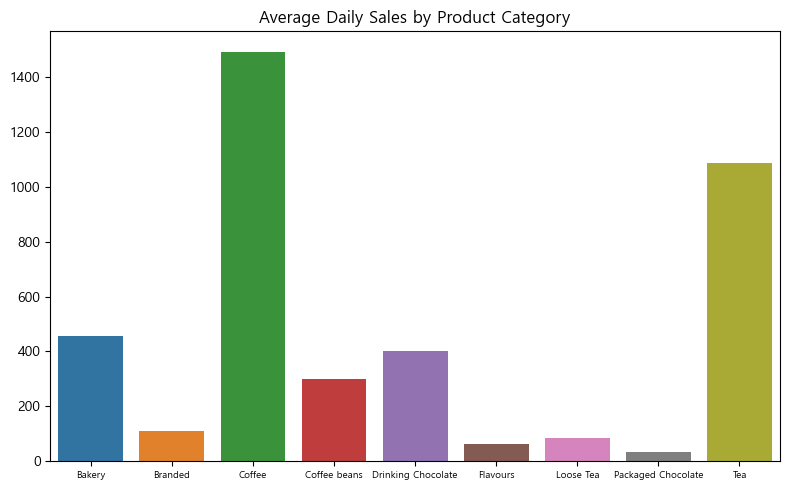

In [88]:
plt.figure(figsize=(8,5))
sns.barplot(data=df_category,x='product_category',y='product_revenue',hue='product_category')
plt.title('Average Daily Sales by Product Category')
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=7)
plt.tight_layout()

In [87]:
weekday_dict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
df_weekday=df_main.assign(weekday=df_main.transaction_date.dt.day_of_week).groupby(['transaction_date','weekday']).agg({'product_revenue':'sum'})\
.groupby('weekday').agg({'product_revenue':'mean'}).reset_index().assign(weekday=lambda df:df.weekday.map(weekday_dict))
df_weekday

,weekday,product_revenue
0,Monday,3910.664615
1,Tuesday,3825.228462
2,Wednesday,3858.213077
3,Thursday,3875.683846
4,Friday,3898.961538
5,Saturday,3875.779200
6,Sunday,3781.935000


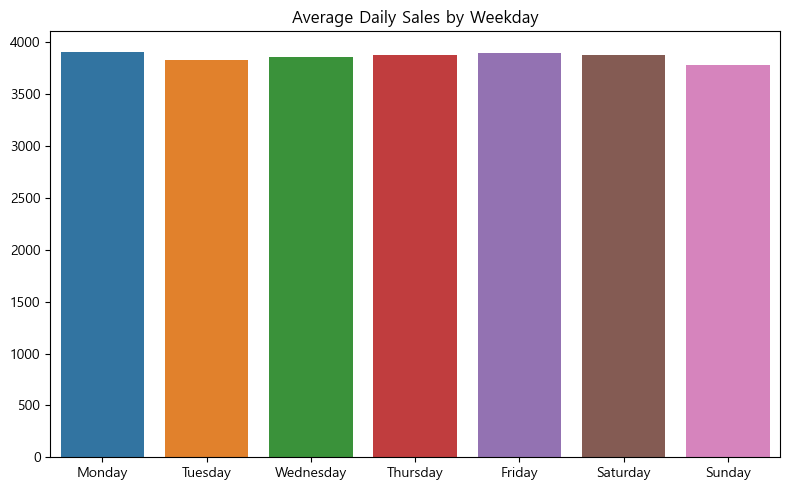

In [89]:
plt.figure(figsize=(8,5))
sns.barplot(data=df_weekday,x='weekday',y='product_revenue',hue='weekday')
plt.title('Average Daily Sales by Weekday')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

In [113]:
df_model=df_main.drop('daily_sales',axis=1).rename({'product_revenue':'sales'},axis=1)\
.assign(month=lambda df:df.transaction_date.dt.month)\
.assign(day=lambda df:df.transaction_date.dt.day)\
.assign(weekday=lambda df:df.transaction_date.dt.day_of_week)
df_model

,transaction_date,store_id,product_id,product_category,product_type,sales,transaction_qty,unit_price,month,day,weekday
0,2023-01-01,3,22,Coffee,Drip coffee,10.00,5,2.00,1,1,6
1,2023-01-01,3,23,Coffee,Drip coffee,17.50,7,2.50,1,1,6
2,2023-01-01,3,24,Coffee,Drip coffee,15.00,5,3.00,1,1,6
3,2023-01-01,3,25,Coffee,Organic brewed coffee,11.00,5,2.20,1,1,6
4,2023-01-01,3,26,Coffee,Organic brewed coffee,12.00,4,3.00,1,1,6
...,...,...,...,...,...,...,...,...,...,...,...
31759,2023-06-30,8,77,Bakery,Scone,15.00,5,3.00,6,30,4
31760,2023-06-30,8,78,Bakery,Scone,36.00,8,4.50,6,30,4
31761,2023-06-30,8,79,Bakery,Scone,18.75,5,3.75,6,30,4
31762,2023-06-30,8,84,Flavours,Regular syrup,6.40,8,0.80,6,30,4


In [120]:
X = df_model.drop('sales',axis=1)
y = df_model['sales']

In [119]:
X_ohe = pd.get_dummies(X)

In [128]:
from sklearn.preprocessing import LabelEncoder
X_le = X.copy()
for col in X.select_dtypes('object').columns.to_list():
    le = LabelEncoder()
    X_le[col] = le.fit_transform(X_le[col])

In [133]:
X_ohe_train, X_ohe_test= train_test_split(X_ohe, test_size=0.2, shuffle=False)
X_le_train, X_le_test= train_test_split(X_le, test_size=0.2, shuffle=False)
y_train, y_test = train_test_split(y, test_size=0.2, shuffle=False)

In [142]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [145]:
model_linear = LinearRegression()
model_linear.fit(X_ohe_train.drop('transaction_date',axis=1), y_train)

LinearRegression()

In [146]:
y_pred_linear = model_linear.predict(X_ohe_test.drop('transaction_date',axis=1))
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
rmse_linear

14.74936533365736

In [147]:
from sklearn.linear_model import Ridge

In [149]:
ridge = Ridge()
ridge.fit(X_ohe_train.drop('transaction_date', axis=1),y_train)

Ridge()

In [150]:
y_pred_ridge = ridge.predict(X_ohe_test.drop('transaction_date',axis=1))
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
rmse_ridge

14.751083080929307

In [151]:
from sklearn.linear_model import Lasso

In [152]:
lasso = Lasso()
lasso.fit(X_ohe_train.drop('transaction_date', axis=1),y_train)

Lasso()

In [153]:
y_pred_lasso = lasso.predict(X_ohe_test.drop('transaction_date',axis=1))
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
rmse_lasso

15.82020197291457

In [148]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [43]:
xgb_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

In [44]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'min_child_weight': [1, 3, 5]
}

In [45]:
grid = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_squared_error')

In [46]:
best_xgb = grid.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

In [47]:
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"RMSE: {rmse_xgb:.2f}")

RMSE: 136.33


- XGBoost 모형은 여러 약한 결정나무를 순차적으로 학습하며 잔차를 보정하는 부스팅 앙상블 방식으로, 복잡한 변수 간 상호작용과 비선형성을 효과적으로 포착한다.
- GridSearchCV를 통해 max_depth=7, learning_rate=0.2, n_estimators=200, min_child_weight=5의 최적 파라미터를 도출하였다.
- 데이터는 훈련 70%, 테스트 30%로 분할하여 학습하였고, 예측 성능 평가는 RMSE를 기준으로 진행하였다. 
- 테스트 데이터 RMSE는 136.33으로 의사결정나무보다 성능이 약간 향상되었다.

<div style="page-break-before: always;"></div>

### 성능비교

In [48]:
models = ['Linear', 'Ridge', 'Lasso', 'GAM', 'Tree', 'XGBoost']
rmses = [1194.48, 1194.48, 1194.39, 1165.19, 137.57, 136.33]

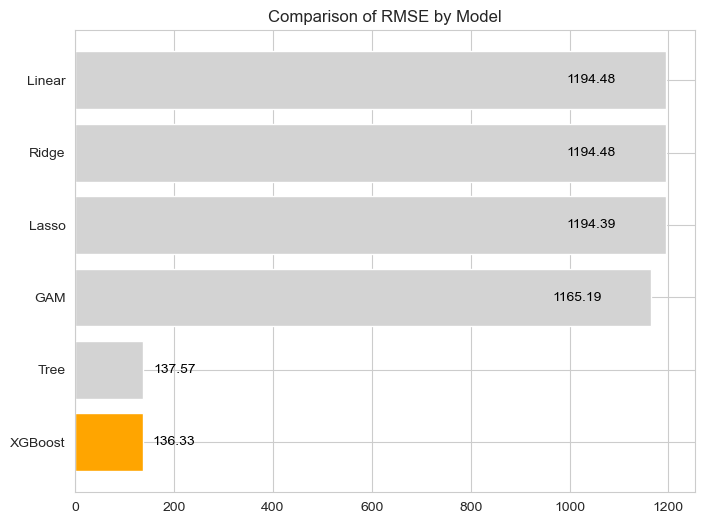

In [64]:
plt.figure(figsize=(8, 6))
bars=plt.barh(models, rmses, color=['lightgray','lightgray','lightgray','lightgray','lightgray','orange'])

for model, bar, rmse in zip(models, bars, rmses):
    width = bar.get_width()
    if model in ['Tree', 'XGBoost']:
        plt.text(width + 20, bar.get_y() + bar.get_height() / 2,
                 f"{rmse:.2f}", va='center', ha='left', color='black', fontsize=10)
    else:
        plt.text(width - 100, bar.get_y() + bar.get_height() / 2,
                 f"{rmse:.2f}", va='center', ha='right', color='black', fontsize=10)

plt.title("Comparison of RMSE by Model")
plt.gca().invert_yaxis()
plt.show()

- 선형모형 계열에서는 모두 RMSE가 1194 내외로 유사한 수준이었으나, 이는 데이터가 선형모형으로는 잘 설명되지 않음을 의미한다.
- 반면, 트리 기반 모델은 변수 간 상호작용 및 비선형 분포를 효과적으로 포착함으로써 RMSE를 137 수준까지 낮추었고, XGBoost는 여기에 더해 오차 보정을 통해 가장 우수한 성능을 기록하였다.

<div style="page-break-before: always;"></div>

### 변수 중요도

In [50]:
importances = pd.Series(best_xgb.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False).head(15)

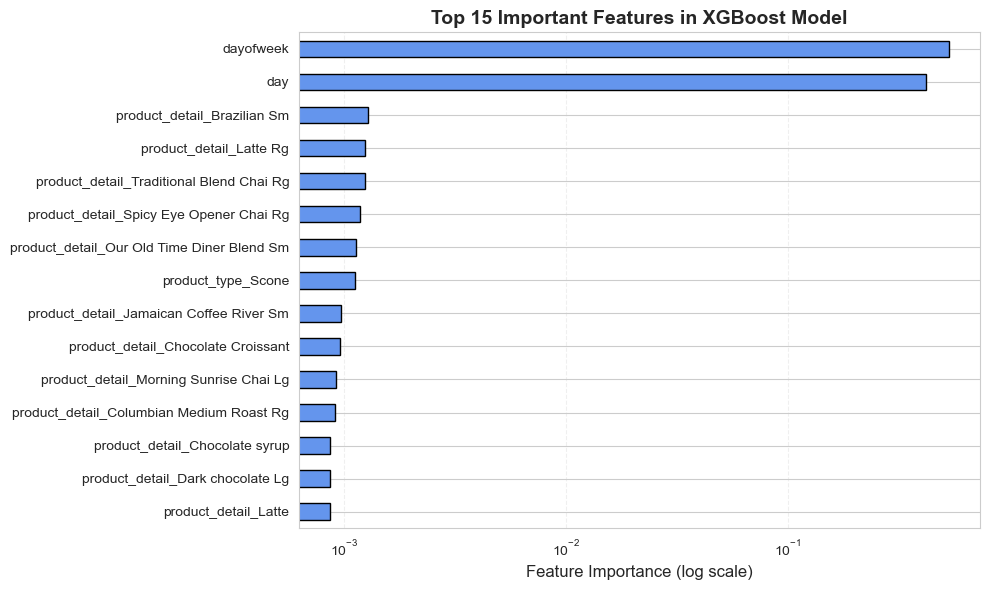

In [65]:
plt.figure(figsize=(10, 6))
top_features.plot(kind='barh', color='cornflowerblue', edgecolor='black')

plt.xlabel("Feature Importance (log scale)", fontsize=12)
plt.title("Top 15 Important Features in XGBoost Model", fontsize=14, fontweight='bold')
plt.xscale('log')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

- 최적의 모형으로 뽑힌 XGBoost에서 어떠한 변수가 크게 중요한지 살펴보았을 때 거래 요일에 해당하는 dayofweek와 거래일에 해당하는 day의 중요도가 가장 높게 나왔다.
- 이는 특정 요일이나 날짜에 따라 매출액이 크게 달라지며 고객 행동 패턴(예: 주말에 더 붐빔, 평일은 한산함 등)을 반영한 결과로 받아들일 수 있다.